* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [17]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
model.objective = "BIOMASS_RT" 


In [18]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1] # the fifth glc uptake value was calculated

# medium = model.medium
# medium["EX_glc__D_e"] = glucose_uptakes[3]
# model.medium = medium
solution = model.optimize()

In [19]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 


In [20]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, glucose_uptake):
    cofactor_fluxes = pd.DataFrame() 

    medium = model.medium
    medium["EX_glc__D_e"] = glucose_uptake
    model.medium = medium
        
    solution = model.optimize()
    biomass_GR = solution.objective_value
    print(f'Biomass growth rate: {biomass_GR}')
    for metabolite in cofactor_list:
        cofactor_fluxes = pd.concat([cofactor_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux, getattr(model.metabolites, metabolite).summary().producing_flux])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column
    else:
        print('error')

    return cofactor_fluxes, biomass_GR

In [21]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold, producing_fluxes_chart = True): # threshold shows the percent of the flux for including in others sector on pie chart 
        
    if producing_fluxes_chart: 
        # The three lines below are for grouping together reactions with low fluxes
        producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]
        producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other'
        producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')['percent'].sum().reset_index() 
     
        y = producing_cofactor_fluxes_draw['percent']
        labels = producing_cofactor_fluxes_draw['reaction']
        pie_chart = plt.pie(y, labels = labels, autopct='%1.1f%%') #, figsize=(5, 5)
        plt.title(title)
        plt.show()
        
    else:
        # The three lines below are for grouping together reactions with low fluxes
        consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
        consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other'
        consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')['percent'].sum().reset_index()
        
        y = consuming_cofactor_fluxes_draw['percent']
        labels = consuming_cofactor_fluxes_draw['reaction']
        pie_chart = plt.pie(y, labels = labels, autopct='%1.1f%%')  
        plt.title(title)
        plt.show()  
    return pie_chart

In [22]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(nadphs, glucose_uptakes[0])
print(biomass_GR_lowest)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(nadphs, glucose_uptakes[5])
print(biomass_GR_highest)
nadph_fluxes_highest_GR


Biomass growth rate: 0.03371300470226846
SUM produced: 0.6029655918074083, SUM consumed: -0.6029655918092072
0.03371300470226846
Biomass growth rate: 0.23226737366171848
SUM produced: 3.974735575038466, SUM consumed: -3.974735575038467
0.23226737366171848


,flux,reaction,percent
ALCD2y,3.558828,ALCD2y,0.895362
ALDD2ym,0.237213,ALDD2ym,0.059680
PYDXOR,0.164037,PYDXOR,0.041270
PPND2,0.014657,PPND2,0.003687
COQ7_m,-0.000172,COQ7_m,0.000043
3NPHBH2_m,-0.000172,3NPHBH2_m,0.000043
DPR,-0.000179,DPR,0.000045
HEMEASm,-0.000321,HEMEASm,0.000081
KYN3OX,-0.000391,KYN3OX,0.000098
DHFR,-0.001492,DHFR,0.000375


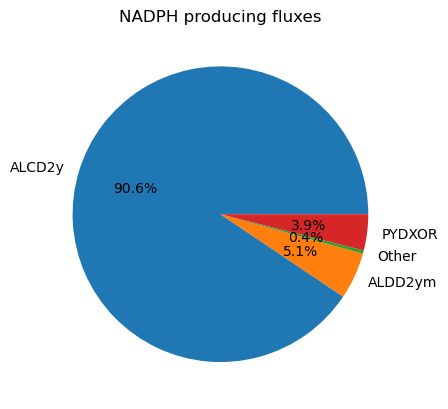

([<matplotlib.patches.Wedge at 0x22ddfcfe3c0>,
 [Text(-1.052221522951804, 0.32067096319590066, 'ALCD2y'),
  Text(0.99942512462171, -0.459509978427977, 'ALDD2ym'),
  Text(1.063257211572099, -0.28192925006094144, 'Other'),
  Text(1.0915467081209311, -0.13610945591823898, 'PYDXOR')],
 [Text(-0.5739390125191657, 0.17491143447049123, '90.6%'),
  Text(0.5451409770663872, -0.2506418064152601, '5.1%'),
  Text(0.5799584790393266, -0.15377959094233168, '0.4%'),
  Text(0.5953891135205078, -0.07424152140994852, '3.9%')])

In [23]:
# Make a pie plot for napdh producing fluxes
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = 'NADPH producing fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold,  True)
producing_nadph_fluxes_lowest_GR_pie_chart

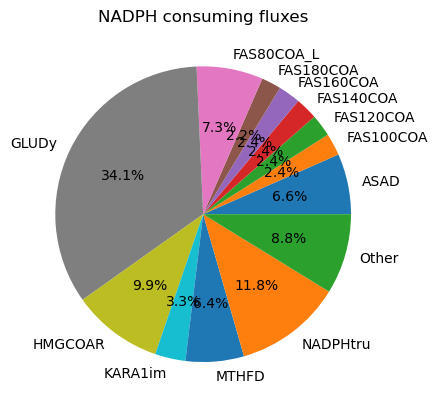

([<matplotlib.patches.Wedge at 0x22ddff99340>,
 [Text(1.0763270674120216, 0.22698027217412015, 'ASAD'),
  Text(0.9696776868017315, 0.5193507328567502, 'FAS100COA'),
  Text(0.8798125180465453, 0.6602499019981736, 'FAS120COA'),
  Text(0.7696401679418503, 0.7859096715847445, 'FAS140COA'),
  Text(0.6417035531288476, 0.8934296558217735, 'FAS160COA'),
  Text(0.5072046197583028, 0.976085792180091, 'FAS180COA'),
  Text(0.20073894294220038, 1.0815284909730525, 'FAS80COA_L'),
  Text(-0.9884514080382729, 0.48266325108418584, 'GLUDy'),
  Text(-0.65811329016213, -0.88141187722425, 'HMGCOAR'),
  Text(-0.24533408042259022, -1.0722924922721422, 'KARA1im'),
  Text(0.08785380977847607, -1.096486072919947, 'MTHFD'),
  Text(0.6655883133527198, -0.8757809070357049, 'NADPHtru'),
  Text(1.058491902717607, -0.2993240583068131, 'Other')],
 [Text(0.5870874913156481, 0.1238074211858837, '6.6%'),
  Text(0.5289151018918534, 0.28328221792186364, '2.4%'),
  Text(0.47989773711629735, 0.3601363101808219, '2.4%'),
  Te

In [24]:
# Make a pie plot for nadph consuming fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'NADPH consuming fluxes'
consuming_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, False)
consuming_nadph_fluxes_lowest_GR_pie_chart

In [25]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(nadhs, glucose_uptakes[0])
print(biomass_GR_lowest)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(nadhs, glucose_uptakes[5])
print(biomass_GR_highest)
nadh_fluxes_highest_GR


Biomass growth rate: 0.03371300470226787
SUM produced: 2.2752295826122757, SUM consumed: -2.2752295826157596
0.03371300470226787
Biomass growth rate: 0.23226737366171848
SUM produced: 13.54695306192316, SUM consumed: -13.546953061923158
0.23226737366171848


,flux,reaction,percent
GAPD,3.623681,GAPD,2.674905e-01
MDHm,2.610327,MDHm,1.926874e-01
PDHm,2.563150,PDHm,1.892049e-01
ICDHxm,2.256605,ICDHxm,1.665766e-01
AKGDm,2.048078,AKGDm,1.511837e-01
IPMD,0.074373,IPMD,5.490030e-03
MMSAD3m,0.042601,MMSAD3m,3.144716e-03
3HPDm,0.042601,3HPDm,3.144716e-03
HICITDm,0.040028,HICITDm,2.954728e-03
SACCD2,0.040028,SACCD2,2.954728e-03


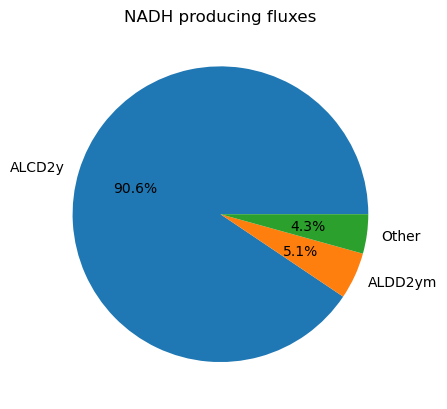

([<matplotlib.patches.Wedge at 0x22de1465760>,
 [Text(-1.052221522951804, 0.32067096319590066, 'ALCD2y'),
  Text(0.99942512462171, -0.459509978427977, 'ALDD2ym'),
  Text(1.089971018846588, -0.14819979107451853, 'Other')],
 [Text(-0.5739390125191657, 0.17491143447049123, '90.6%'),
  Text(0.5451409770663872, -0.2506418064152601, '5.1%'),
  Text(0.5945296466435934, -0.0808362496770101, '4.3%')])

In [26]:
# Make a pie plot for nadh producing fluxes
threshold = 0.05 # threshold for including reaction in group 'others' in pie chart
title = 'NADH producing fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, True)
producing_nadph_fluxes_lowest_GR_pie_chart

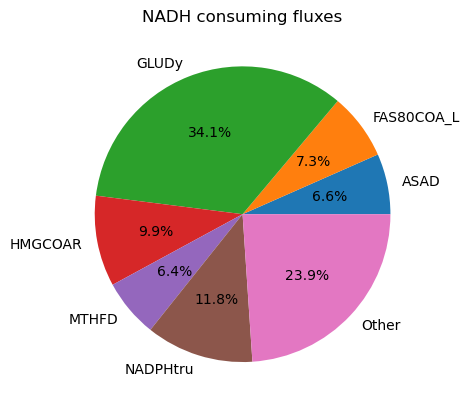

([<matplotlib.patches.Wedge at 0x22de04d2120>,
 [Text(1.0763270674120216, 0.22698027217412015, 'ASAD'),
  Text(0.8798125180465453, 0.6602499019981736, 'FAS80COA_L'),
  Text(-0.40091085566870815, 1.0243390482681916, 'GLUDy'),
  Text(-1.081038259405461, -0.20336243925959233, 'HMGCOAR'),
  Text(-0.8428639627290578, -0.7068099746980582, 'MTHFD'),
  Text(-0.32828049532447784, -1.0498723333765472, 'NADPHtru'),
  Text(0.803320062389081, -0.7514498501984035, 'Other')],
 [Text(0.5870874913156481, 0.1238074211858837, '6.6%'),
  Text(0.47989773711629735, 0.3601363101808219, '7.3%'),
  Text(-0.21867864854656807, 0.558730389964468, '34.1%'),
  Text(-0.5896572324029787, -0.11092496686886853, '9.9%'),
  Text(-0.45974397967039515, -0.38553271347166806, '6.4%'),
  Text(-0.17906208835880608, -0.5726576363872075, '11.8%'),
  Text(0.43817457948495325, -0.4098817364718564, '23.9%')])

In [27]:
# Make a pie plot for nadh consuming fluxes
threshold = 0.05 
title = 'NADH consuming fluxes'
consuming_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, False)
consuming_nadph_fluxes_lowest_GR_pie_chart

In [28]:
# Get atp fluxes at lowest biomass growth rate

atps_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(atps, glucose_uptakes[0])
print(biomass_GR_lowest)
atps_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atps_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(atps, glucose_uptakes[5])
print(biomass_GR_highest)
atps_fluxes_highest_GR

Biomass growth rate: 0.03371300470226787
SUM produced: 14.71673867089873, SUM consumed: -14.716738670898733
0.03371300470226787
Biomass growth rate: 0.23226737366171848
SUM produced: 86.14262425578717, SUM consumed: -86.1426242557872
0.23226737366171848


,flux,reaction,percent
ATPtm,38.609989,ATPtm,0.448210
ATPS3m,37.076549,ATPS3m,0.430409
PGK,3.623681,PGK,0.042066
PYK,3.536733,PYK,0.041057
SUCOASm,2.046794,SUCOASm,0.023761
...,...,...,...
PFK,-1.413703,PFK,0.016411
ADK1,-2.757378,ADK1,0.032009
HEX1,-3.100000,HEX1,0.035987
BIOMASS_RT,-32.445127,BIOMASS_RT,0.376644


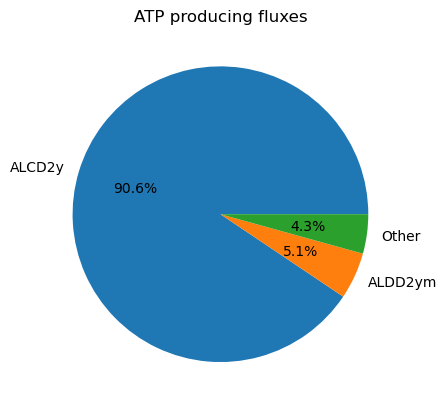

([<matplotlib.patches.Wedge at 0x22de03a8a70>,
 [Text(-1.052221522951804, 0.32067096319590066, 'ALCD2y'),
  Text(0.99942512462171, -0.459509978427977, 'ALDD2ym'),
  Text(1.089971018846588, -0.14819979107451853, 'Other')],
 [Text(-0.5739390125191657, 0.17491143447049123, '90.6%'),
  Text(0.5451409770663872, -0.2506418064152601, '5.1%'),
  Text(0.5945296466435934, -0.0808362496770101, '4.3%')])

In [29]:
# Make a pie plot for atp producing fluxes
threshold = 0.05 # threshold for including reaction in group 'others' in pie chart
title = 'ATP producing fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title,  threshold, True)
producing_nadph_fluxes_lowest_GR_pie_chart

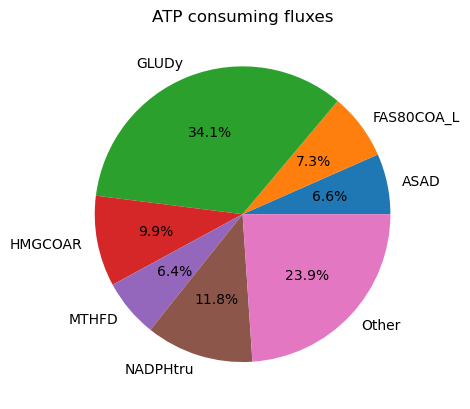

([<matplotlib.patches.Wedge at 0x22dd0840aa0>,
 [Text(1.0763270674120216, 0.22698027217412015, 'ASAD'),
  Text(0.8798125180465453, 0.6602499019981736, 'FAS80COA_L'),
  Text(-0.40091085566870815, 1.0243390482681916, 'GLUDy'),
  Text(-1.081038259405461, -0.20336243925959233, 'HMGCOAR'),
  Text(-0.8428639627290578, -0.7068099746980582, 'MTHFD'),
  Text(-0.32828049532447784, -1.0498723333765472, 'NADPHtru'),
  Text(0.803320062389081, -0.7514498501984035, 'Other')],
 [Text(0.5870874913156481, 0.1238074211858837, '6.6%'),
  Text(0.47989773711629735, 0.3601363101808219, '7.3%'),
  Text(-0.21867864854656807, 0.558730389964468, '34.1%'),
  Text(-0.5896572324029787, -0.11092496686886853, '9.9%'),
  Text(-0.45974397967039515, -0.38553271347166806, '6.4%'),
  Text(-0.17906208835880608, -0.5726576363872075, '11.8%'),
  Text(0.43817457948495325, -0.4098817364718564, '23.9%')])

In [30]:
# Make a pie plot for atp consuming fluxes
title = 'ATP consuming fluxes'
threshold = 0.05 
consuming_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, False)
consuming_nadph_fluxes_lowest_GR_pie_chart

In [31]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\Biomass_maximization\\Cofactor_balances\\all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)

    